In [3]:
import librosa
import os
import json

DATASET_PATH = "/content/dataset"
JSON_PATH = "data.json"
SAMPLES_TO_CONSIDER = 22050 # 1 sec. of audio


def preprocess_dataset(dataset_path, json_path, num_mfcc=13, n_fft=2048, hop_length=512):
    """Extracts MFCCs from music dataset and saves them into a json file.
    :param dataset_path (str): Path to dataset
    :param json_path (str): Path to json file used to save MFCCs
    :param num_mfcc (int): Number of coefficients to extract
    :param n_fft (int): Interval we consider to apply FFT. Measured in # of samples
    :param hop_length (int): Sliding window for FFT. Measured in # of samples
    :return:
    """

    # dictionary where we'll store mapping, labels, MFCCs and filenames
    data = {
        "mapping": [],
        "labels": [],
        "MFCCs": [],
        "files": []
    }

    # loop through all sub-dirs
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

        # ensure we're at sub-folder level
        if dirpath is not dataset_path:

            # save label (i.e., sub-folder name) in the mapping
            label = dirpath.split("/")[-1]
            data["mapping"].append(label)
            print("\nProcessing: '{}'".format(label))

            # process all audio files in sub-dir and store MFCCs
            for f in filenames:
                file_path = os.path.join(dirpath, f)

                # load audio file and slice it to ensure length consistency among different files
                signal, sample_rate = librosa.load(file_path)

                # drop audio files with less than pre-decided number of samples
                if len(signal) >= SAMPLES_TO_CONSIDER:

                    # ensure consistency of the length of the signal
                    signal = signal[:SAMPLES_TO_CONSIDER]

                    # extract MFCCs
                    MFCCs = librosa.feature.mfcc(signal, sample_rate, n_mfcc=num_mfcc, n_fft=n_fft,
                                                 hop_length=hop_length)

                    # store data for analysed track
                    data["MFCCs"].append(MFCCs.T.tolist())
                    data["labels"].append(i-1)
                    data["files"].append(file_path)
                    print("{}: {}".format(file_path, i-1))

    # save data in json file
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)


if __name__ == "__main__":
    preprocess_dataset(DATASET_PATH, JSON_PATH)


Processing: '.ipynb_checkpoints'

Processing: 'ode'
/content/dataset/ode/ode_8.wav: 1
/content/dataset/ode/ode_3.wav: 1
/content/dataset/ode/ode_5.wav: 1
/content/dataset/ode/ode_6.wav: 1
/content/dataset/ode/ode_1.wav: 1
/content/dataset/ode/ode_4.wav: 1
/content/dataset/ode/ode_2.wav: 1
/content/dataset/ode/ode_12.wav: 1
/content/dataset/ode/ode_11.wav: 1
/content/dataset/ode/ode_10.wav: 1

Processing: 'kochurmek'
/content/dataset/kochurmek/kochur_5.wav: 2
/content/dataset/kochurmek/kochur_7.wav: 2
/content/dataset/kochurmek/kochur_4.wav: 2
/content/dataset/kochurmek/kochur_1.wav: 2
/content/dataset/kochurmek/kochur_6.wav: 2
/content/dataset/kochurmek/kochur_2.wav: 2
/content/dataset/kochurmek/kochur_3.wav: 2


Training sets loaded!
(10, 44, 13, 1)
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 42, 11, 32)        320       
                                                                 
 batch_normalization_19 (Bat  (None, 42, 11, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 21, 6, 32)        0         
 g2D)                                                            
                                                                 
 flatten_11 (Flatten)        (None, 4032)              0         
                                                                 
 dense_22 (Dense)            (None, 64)                258112    
                                                                 
 dense_23 (Dens

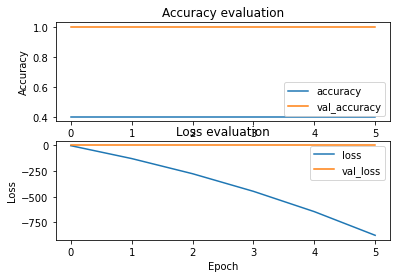

1/1 [==============================] - 0s 23ms/step - loss: -1556.4717 - accuracy: 0.7500

Test loss: -1556.4716796875, test accuracy: 75.0


In [17]:
import json
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pickle

DATA_PATH = "data.json"
SAVED_MODEL_PATH = "model.h5"
EPOCHS = 40
BATCH_SIZE = 32
PATIENCE = 5
LEARNING_RATE = 0.01


def load_data(data_path):
    """Loads training dataset from json file.
    :param data_path (str): Path to json file containing data
    :return X (ndarray): Inputs
    :return y (ndarray): Targets
    """
    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["MFCCs"])
    y = np.array(data["labels"])
    print("Training sets loaded!")
    return X, y


def prepare_dataset(data_path, test_size=0.2, validation_size=0.2):
    """Creates train, validation and test sets.
    :param data_path (str): Path to json file containing data
    :param test_size (flaot): Percentage of dataset used for testing
    :param validation_size (float): Percentage of train set used for cross-validation
    :return X_train (ndarray): Inputs for the train set
    :return y_train (ndarray): Targets for the train set
    :return X_validation (ndarray): Inputs for the validation set
    :return y_validation (ndarray): Targets for the validation set
    :return X_test (ndarray): Inputs for the test set
    :return X_test (ndarray): Targets for the test set
    """

    # load dataset
    X, y = load_data(data_path)

    # create train, validation, test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # add an axis to nd array
    X_train = X_train[..., np.newaxis]
    X_test = X_test[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]

    return X_train, y_train, X_validation, y_validation, X_test, y_test


def build_model(input_shape, loss="sparse_categorical_crossentropy", learning_rate=0.0001):
    """Build neural network using keras.
    :param input_shape (tuple): Shape of array representing a sample train. E.g.: (44, 13, 1)
    :param loss (str): Loss function to use
    :param learning_rate (float):
    :return model: TensorFlow model
    """

    # build network architecture using convolutional layers
    model = tf.keras.models.Sequential()

    # 1st conv layer
    # model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape,
    #                                  kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    # model.add(tf.keras.layers.BatchNormalization())
    # model.add(tf.keras.layers.MaxPooling2D((3, 3), strides=(2,2), padding='same'))

    # 2nd conv layer
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu',input_shape=input_shape,
                                     kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D((3, 3), strides=(2,2), padding='same'))

    # # 3rd conv layer
    # model.add(tf.keras.layers.Conv2D(32, (2, 2), activation='relu',
    #                                  kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    # model.add(tf.keras.layers.BatchNormalization())
    # model.add(tf.keras.layers.MaxPooling2D((2, 2), strides=(2,2), padding='same'))

    # flatten output and feed into dense layer
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    tf.keras.layers.Dropout(0.3)

    # softmax output layer
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    optimiser = tf.optimizers.Adam(learning_rate=learning_rate)

    # compile model
    model.compile(optimizer=optimiser,
                  loss='binary_crossentropy' ,
                  metrics=["accuracy"])

    # print model parameters on console
    model.summary()

    return model


def train(model, epochs, batch_size, patience, X_train, y_train, X_validation, y_validation):
    """Trains model
    :param epochs (int): Num training epochs
    :param batch_size (int): Samples per batch
    :param patience (int): Num epochs to wait before early stop, if there isn't an improvement on accuracy
    :param X_train (ndarray): Inputs for the train set
    :param y_train (ndarray): Targets for the train set
    :param X_validation (ndarray): Inputs for the validation set
    :param y_validation (ndarray): Targets for the validation set
    :return history: Training history
    """

    earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor="accuracy", min_delta=0.001, patience=patience)

    # train model
    history = model.fit(X_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_validation, y_validation),
                        callbacks=[earlystop_callback])
    return history


def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs
    :param history: Training history of model
    :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy subplot
    axs[0].plot(history.history["accuracy"], label="accuracy")
    axs[0].plot(history.history['val_accuracy'], label="val_accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy evaluation")

    # create loss subplot
    axs[1].plot(history.history["loss"], label="loss")
    axs[1].plot(history.history['val_loss'], label="val_loss")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Loss")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Loss evaluation")

    plt.show()


def main():
    # generate train, validation and test sets
    X_train, y_train, X_validation, y_validation, X_test, y_test = prepare_dataset(DATA_PATH)
    print(X_train.shape)

    # create network
    input_shape = (X_train.shape[1], X_train.shape[2], 1)
    model = build_model(input_shape, learning_rate=LEARNING_RATE)

    # train network
    history = train(model, EPOCHS, BATCH_SIZE, PATIENCE, X_train, y_train, X_validation, y_validation)

    # plot accuracy/loss for training/validation set as a function of the epochs
    plot_history(history)

    # evaluate network on test set
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print("\nTest loss: {}, test accuracy: {}".format(test_loss, 100*test_acc))

    # save model
    model.save(SAVED_MODEL_PATH)


if __name__ == "__main__":
    main()


In [23]:
import librosa
import tensorflow as tf
import numpy as np

SAVED_MODEL_PATH = "model.h5"
SAMPLES_TO_CONSIDER = 22050

class _Keyword_Spotting_Service:
    """Singleton class for keyword spotting inference with trained models.
    :param model: Trained model
    """

    model = None
    _mapping = [
        "kochurmek",
        "ode",
    ]
    _instance = None


    def predict(self, file_path):
        """
        :param file_path (str): Path to audio file to predict
        :return predicted_keyword (str): Keyword predicted by the model
        """

        # extract MFCC
        MFCCs = self.preprocess(file_path)

        # we need a 4-dim array to feed to the model for prediction: (# samples, # time steps, # coefficients, 1)
        MFCCs = MFCCs[np.newaxis, ..., np.newaxis]

        # get the predicted label
        predictions = self.model.predict(MFCCs)
        predicted_index = np.argmax(predictions)
        predicted_keyword = self._mapping[predicted_index]
        return predicted_keyword


    def preprocess(self, file_path, num_mfcc=13, n_fft=2048, hop_length=512):
        """Extract MFCCs from audio file.
        :param file_path (str): Path of audio file
        :param num_mfcc (int): # of coefficients to extract
        :param n_fft (int): Interval we consider to apply STFT. Measured in # of samples
        :param hop_length (int): Sliding window for STFT. Measured in # of samples
        :return MFCCs (ndarray): 2-dim array with MFCC data of shape (# time steps, # coefficients)
        """

        # load audio file
        signal, sample_rate = librosa.load(file_path)

        if len(signal) >= SAMPLES_TO_CONSIDER:
            # ensure consistency of the length of the signal
            signal = signal[:SAMPLES_TO_CONSIDER]

            # extract MFCCs
            MFCCs = librosa.feature.mfcc(signal, sample_rate, n_mfcc=num_mfcc, n_fft=n_fft,
                                         hop_length=hop_length)
        return MFCCs.T


def Keyword_Spotting_Service():
    """Factory function for Keyword_Spotting_Service class.
    :return _Keyword_Spotting_Service._instance (_Keyword_Spotting_Service):
    """

    # ensure an instance is created only the first time the factory function is called
    if _Keyword_Spotting_Service._instance is None:
        _Keyword_Spotting_Service._instance = _Keyword_Spotting_Service()
        _Keyword_Spotting_Service.model = tf.keras.models.load_model(SAVED_MODEL_PATH)
    return _Keyword_Spotting_Service._instance




if __name__ == "__main__":

    # create 2 instances of the keyword spotting service
    kss = Keyword_Spotting_Service()
    kss1 = Keyword_Spotting_Service()

    # check that different instances of the keyword spotting service point back to the same object (singleton)
    assert kss is kss1

    # make a prediction
    keyword = kss.predict("/content/kochurme.test.wav")
    print(keyword)

kochurmek
